# Bicycle Sharing Stations Bordeaux

Analyze the daily profile for each station from 2017-07-09 to 2017-09-26.

## Some Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.cluster import KMeans

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')

## Watermark for the versions of used libs

In [5]:
%load_ext watermark

In [6]:
%watermark -d -v -p numpy,pandas,sklearn,matplotlib,seaborn -g -m -w

2017-10-17 

CPython 3.5.4
IPython 6.2.0

numpy 1.12.1
pandas 0.20.3
sklearn 0.19.0
matplotlib 2.0.2
seaborn 0.8.1

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.12.0-1-amd64
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit
Git hash   : b4820d2727db0f1762440b8fa0cb512a0994c594
watermark 1.5.0


## Load Data

In [7]:
# Timeseries data
DATA = "data/bordeaux.csv"

In [8]:
raw = pd.read_csv(DATA, parse_dates=['ts'])

In [9]:
raw.head()

,gid,ident,type,name,state,available_stand,available_bike,ts
0,83,1,VLS,Meriadeck,CONNECTEE,16,4,2017-09-01 00:04:04
1,84,2,VLS,St Bruno,CONNECTEE,7,12,2017-09-01 00:04:04
2,41,3,VLS,Place Tartas,CONNECTEE,0,18,2017-09-01 00:04:04
3,42,4,VLS,St Seurin,CONNECTEE,20,0,2017-09-01 00:04:04
4,43,5,VLS,Place Gambetta,CONNECTEE,37,3,2017-09-01 00:04:04


## Some Cleaning

In [10]:
print(raw.shape)

(2310198, 8)


* Get only `CONNECTEE` station (i.e. not closed)
* Rename some columns
* Drop duplicates

In [11]:
data = (raw.copy()
        .query('state == "CONNECTEE"')
        .drop(['gid', 'available_stand', 'type', 'state'], axis=1)
        .rename_axis({"available_bike": "bikes", "ident": "station"}, axis=1)
        .drop_duplicates()
        .sort_values(["station", "ts"]))

In [12]:
print(data.shape)
data.head()

(2199551, 4)


,station,name,bikes,ts
0,1,Meriadeck,4,2017-09-01 00:04:04
174,1,Meriadeck,4,2017-09-01 00:09:04
348,1,Meriadeck,3,2017-09-01 00:14:04
522,1,Meriadeck,3,2017-09-01 00:19:03
696,1,Meriadeck,2,2017-09-01 00:24:04


## Timeseries resampling

Get data every 5 minutes.

In [13]:
df = (data.set_index("ts")
      .groupby("station")["bikes"]
      .resample("5T")
      .mean()
      .bfill()
      .unstack(0))

In [14]:
print(df.shape)
df.head()

(13358, 169)


station,1,2,3,4,5,6,7,8,9,10,...,165,166,167,168,169,170,171,172,173,174
ts,,,,,,,,,,,,,,,,,,,,,
2017-09-01 00:00:00,4.0,12.0,18.0,0.0,3.0,0.0,1.0,5.0,16.0,0.0,...,11.0,11.0,11.0,11.0,4.0,6.0,8.0,0.0,8.0,0.0
2017-09-01 00:05:00,4.0,14.0,18.0,2.0,3.0,0.0,0.0,5.0,16.0,1.0,...,11.0,11.0,11.0,11.0,4.0,5.0,8.0,0.0,8.0,0.0
2017-09-01 00:10:00,3.0,14.0,18.0,2.0,1.0,0.0,2.0,5.0,15.0,2.0,...,11.0,11.0,11.0,11.0,4.0,5.0,7.0,2.0,8.0,0.0
2017-09-01 00:15:00,3.0,13.0,18.0,2.0,0.0,0.0,3.0,5.0,15.0,2.0,...,11.0,11.0,11.0,11.0,4.0,5.0,7.0,0.0,8.0,0.0
2017-09-01 00:20:00,2.0,13.0,18.0,2.0,0.0,0.0,3.0,5.0,15.0,2.0,...,11.0,11.0,11.0,11.0,4.0,5.0,8.0,0.0,8.0,0.0


## Get rid of saturday and sunday

In [15]:
weekday = df.index.weekday

In [16]:
mask = weekday < 5

In [17]:
mask.sum()

9326

In [18]:
df = df[mask]

In [19]:
print(df.shape)

(9326, 169)


## Get the daily profile

In [20]:
df['hour'] = df.index.hour

In [21]:
df.head()

station,1,2,3,4,5,6,7,8,9,10,...,166,167,168,169,170,171,172,173,174,hour
ts,,,,,,,,,,,,,,,,,,,,,
2017-09-01 00:00:00,4.0,12.0,18.0,0.0,3.0,0.0,1.0,5.0,16.0,0.0,...,11.0,11.0,11.0,4.0,6.0,8.0,0.0,8.0,0.0,0
2017-09-01 00:05:00,4.0,14.0,18.0,2.0,3.0,0.0,0.0,5.0,16.0,1.0,...,11.0,11.0,11.0,4.0,5.0,8.0,0.0,8.0,0.0,0
2017-09-01 00:10:00,3.0,14.0,18.0,2.0,1.0,0.0,2.0,5.0,15.0,2.0,...,11.0,11.0,11.0,4.0,5.0,7.0,2.0,8.0,0.0,0
2017-09-01 00:15:00,3.0,13.0,18.0,2.0,0.0,0.0,3.0,5.0,15.0,2.0,...,11.0,11.0,11.0,4.0,5.0,7.0,0.0,8.0,0.0,0
2017-09-01 00:20:00,2.0,13.0,18.0,2.0,0.0,0.0,3.0,5.0,15.0,2.0,...,11.0,11.0,11.0,4.0,5.0,8.0,0.0,8.0,0.0,0


In [22]:
profile = df.groupby("hour").mean()

In [23]:
profile.head()

station,1,2,3,4,5,6,7,8,9,10,...,165,166,167,168,169,170,171,172,173,174
hour,,,,,,,,,,,,,,,,,,,,,
0,1.974747,7.880051,8.280303,4.333333,1.921717,1.434343,3.896465,10.929293,11.911616,5.000000,...,9.239899,9.659091,9.921717,10.090909,5.770202,8.219697,13.916667,3.143939,9.772727,0.989899
1,1.787879,8.517677,8.520202,3.767677,1.737374,1.330808,3.464646,11.398990,13.093434,5.797980,...,9.287879,9.638889,9.954545,10.093434,5.901515,8.479798,14.853535,3.148990,10.174242,0.997475
2,1.598485,8.545455,8.911616,3.436869,1.719697,1.747475,2.479798,11.492424,13.782828,6.378788,...,9.300505,9.636364,9.974747,10.141414,6.083333,8.623737,15.113636,3.679293,10.800505,1.080808
3,1.984848,8.522727,9.106061,3.527778,1.939394,2.005051,2.300505,11.363636,14.022727,6.936869,...,9.383838,9.691919,9.974747,10.174242,6.234848,8.876263,15.042929,4.015152,11.300505,1.103535
4,3.176768,8.757576,9.356061,3.722222,2.174242,2.310606,2.631313,11.858586,14.366162,7.143939,...,9.598485,10.154040,9.974747,10.186869,6.416667,9.042929,15.118687,3.790404,11.497475,1.217172


## Clustering

Use the KMeans algorithm on the daily profile.

In [72]:
n_clusters = 4

In [73]:
# Normalization
df_norm = profile / profile.max()

In [74]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df_norm.T)

In [75]:
labels = pd.Series(kmeans.labels_)

Number of stations for each cluster (i.e. usage pattern).

In [106]:
label_count = labels.groupby(labels).count()
label_count

0    70
1    13
2    55
3    31
dtype: int64

Choose some colors.

In [77]:
colors = sns.color_palette('tab10', n_clusters)

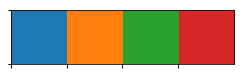

In [78]:
sns.palplot(colors)

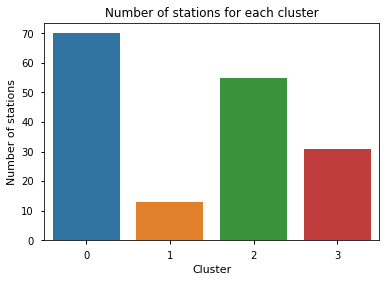

In [112]:
sns.barplot(x=label_count.index, y=label_count, palette='tab10')
plt.xlabel('Cluster')
plt.ylabel('Number of stations')
plt.title('Number of stations for each cluster')

Plot the daily profile of available bikes (%) for each cluster.

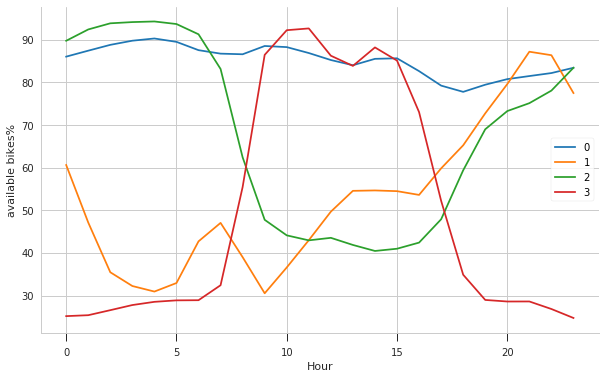

In [81]:
with sns.axes_style("whitegrid", {'xtick.major.size': 8.0}):
    fig, ax = plt.subplots(figsize=(10,6))

for k, label, color in zip(kmeans.cluster_centers_, range(n_clusters), colors):
    plt.plot(100*k, color=color, label=label)
    
plt.legend()
plt.xlabel('Hour')
plt.ylabel("available bikes%")
sns.despine()

## Map

Get the station lat/lon coordinates.

In [84]:
locations = pd.read_csv("data/bordeaux-stations.csv")

In [85]:
locations.head()

,ident,nom,lat,lon
0,138,Lycée Brémontier,44.824055,-0.570243
1,135,Eglise Ste Croix,44.831312,-0.561393
2,79,Buttinière,44.864276,-0.524200
3,3,Porte de Bourgogne,44.837789,-0.567156
4,8,Doyen Brus,44.800385,-0.609857


In [86]:
dflabel = pd.DataFrame({"label": kmeans.labels_}, index=profile.columns)

In [87]:
dflabel.head()

,label
station,
1,3
2,0
3,2
4,1
5,3


Get the label, i.e. the cluster id, for each station.

In [88]:
locations = locations.merge(dflabel, right_index=True, left_on='ident')

In [89]:
locations.head()

,ident,nom,lat,lon,label
0,138,Lycée Brémontier,44.824055,-0.570243,2
1,135,Eglise Ste Croix,44.831312,-0.561393,2
2,79,Buttinière,44.864276,-0.524200,0
3,3,Porte de Bourgogne,44.837789,-0.567156,2
4,8,Doyen Brus,44.800385,-0.609857,0


In [90]:
locations["nom"] = locations['nom'].str.replace("'", "&apos;")

In [39]:
import folium

In [40]:
# Bordeaux (France) position.
position = [44.836151, -0.580816]

In [101]:
mp = folium.Map(location=position, zoom_start=12, tiles='cartodbpositron')

In [96]:
hex_colors = colors.as_hex()

In [102]:
for _,row in locations.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        popup=row['nom'],
        color=hex_colors[row['label']],
        fill=False,
        fill_opacity=0.4,
        fill_color=hex_colors[row['label']]
    ).add_to(mp)

In [113]:
mp.save("bordeaux-map-n_clusters-{}.html".format(n_clusters))

In [103]:
mp